In [ ]:
!pip install tsfel

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

import sklearn
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import GridSearchCV
import sklearn.metrics
from sklearn import preprocessing

import torch
import torch.nn as nn
import torch.utils.data as data_utils

import tensorflow as tf


np.random.seed(0)
tf.random.set_seed(0)

In [ ]:
!git clone https://github.com/MLinApp-FP01-Team7-24/OurProject.git
%cd OurProject

Cloning into 'OurProject'...
remote: Enumerating objects: 1172, done.
remote: Counting objects: 100% (158/158), done.
remote: Compressing objects: 100% (130/130), done.
remote: Total 1172 (delta 53), reused 54 (delta 17), pack-reused 1014
Receiving objects: 100% (1172/1172), 159.16 MiB | 21.45 MiB/s, done.
Resolving deltas: 100% (254/254), done.
/content/OurProject


# Data load

In [ ]:
# Set widnow size and k for point adjustment. 0 is f1, 1 is f1_pa

window_size = 20
k_pa = 0

In [ ]:
from Models.lstm_vae.data import get_data_windows

# Get data for training, calibration and testing in form of numpy arrays. Already windowed and normalized.
data_train, data_cal, label_cal, data_test, label_test = get_data_windows(window_size, k_pa)

print(data_train.shape)
print(data_cal.shape, label_cal.shape)
print(data_test.shape, label_test.shape)

Reading training data...
Reading calibration data...
Reading test data...
Reading collisions data...
Normalizing data...
Getting windows for training data...
Getting windows and labels for calibration data...
Getting windows and labels for test data...
(95795, 20, 55)
(3480, 20, 55) (3480,)
(30755, 20, 55) (30755,)


# USAD

In [ ]:
from Models.usad.utils import *
from Models.usad.usad import *

device = get_default_device()

## Training

In [ ]:
BATCH_SIZE =  256
N_EPOCHS = 5
hidden_size = 50

In [ ]:
w_size=data_train.shape[1]*data_train.shape[2]
z_size=data_train.shape[1]*hidden_size

windows_normal_train = data_train[:int(np.floor(.8 *  data_train.shape[0]))]
windows_normal_val = data_train[int(np.floor(.8 *  data_train.shape[0])):int(np.floor(data_train.shape[0]))]

train_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_normal_train).float().view(([windows_normal_train.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

val_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_normal_val).float().view(([windows_normal_val.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=True, num_workers=0)

model = UsadModel(w_size, z_size)
model = to_device(model,device)

In [ ]:
history = training(N_EPOCHS,model,train_loader,val_loader)

Epoch [0], val_loss1: 0.0842, val_loss2: 0.0780
Epoch [1], val_loss1: 0.0884, val_loss2: -0.0083
Epoch [2], val_loss1: 0.0991, val_loss2: -0.0459
Epoch [3], val_loss1: 0.1004, val_loss2: -0.0622
Epoch [4], val_loss1: 0.0974, val_loss2: -0.0676


In [ ]:
#!mkdir "trained_models/USAD"
torch.save({
            'encoder': model.encoder.state_dict(),
            'decoder1': model.decoder1.state_dict(),
            'decoder2': model.decoder2.state_dict()
            }, "trained_models/USAD/model.pth")

## Model load

In [ ]:
w_size = 1100
z_size = 1000

In [ ]:
model = UsadModel(w_size, z_size)
model = to_device(model,device)

checkpoint = torch.load("trained_models/USAD/model.pth")

model.encoder.load_state_dict(checkpoint['encoder'])
model.decoder1.load_state_dict(checkpoint['decoder1'])
model.decoder2.load_state_dict(checkpoint['decoder2'])

<All keys matched successfully>

## Model Calibration

In [ ]:
cal_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(data_cal).float().view(([data_cal.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [ ]:
results=testing(model,cal_loader,alpha=0.9,beta=0.1)
score_cal=np.concatenate([torch.stack(results[:-1]).flatten().detach().cpu().numpy(),
                              results[-1].flatten().detach().cpu().numpy()])

In [ ]:
score_cal = score_cal.reshape(-1, 1)
score_cal.shape

(3480,)

In [ ]:
# Prova diverse soglie e trova quella che massimizza l'F1-score sui dati di addestramento
best_threshold = 0
best_f1 = 0
for threshold in np.linspace(0, 1, 100):
    y_pred = (X_train >= threshold).astype(int)
    f1 = f1_score(y_train, y_pred)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

# Applica la soglia ottimale ai dati di test
print(f"Soglia ottimale da cross-validation: {best_threshold}")

In [ ]:
optimize = True
param_grid = {'estimator__C': np.logspace(0, 5, 6), 'estimator__gamma': np.logspace(-5, 0, 6)}

if optimize:
  cal_search = GridSearchCV(CalibratedClassifierCV(SVC(probability=True), cv=3), param_grid, cv=3, verbose=1, scoring='f1')
  cal_search.fit(score_cal, label_cal)
  cal_model = cal_search.best_estimator_
  print(cal_search.best_params_)
else:
  cal_model = CalibratedClassifierCV(SVC(probability=True, C=10, gamma=1e-3))
  cal_model.fit(score_cal, label_cal[:score_cal.shape[0]])

Fitting 3 folds for each of 36 candidates, totalling 108 fits


ValueError: 
All the 108 fits failed.
It is very likely that your model is misconfigured.
You can try to debug the error by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
36 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/calibration.py", line 395, in fit
    self.calibrated_classifiers_ = parallel(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/parallel.py", line 63, in __call__
    return super().__call__(iterable_with_config)
  File "/usr/local/lib/python3.10/dist-packages/joblib/parallel.py", line 1918, in __call__
    return output if self.return_generator else list(output)
  File "/usr/local/lib/python3.10/dist-packages/joblib/parallel.py", line 1847, in _get_sequential_output
    res = func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/parallel.py", line 123, in __call__
    return self.function(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/calibration.py", line 577, in _fit_classifier_calibrator_pair
    estimator.fit(X_train, y_train, **fit_params_train)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py", line 192, in fit
    X, y = self._validate_data(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 584, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py", line 1106, in check_X_y
    X = check_array(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py", line 902, in check_array
    raise ValueError(
ValueError: Expected 2D array, got 1D array instead:
array=[0.07619896 0.07780056 0.07707202 ... 0.06638604 0.06643543 0.06835356].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

--------------------------------------------------------------------------------
36 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/calibration.py", line 395, in fit
    self.calibrated_classifiers_ = parallel(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/parallel.py", line 63, in __call__
    return super().__call__(iterable_with_config)
  File "/usr/local/lib/python3.10/dist-packages/joblib/parallel.py", line 1918, in __call__
    return output if self.return_generator else list(output)
  File "/usr/local/lib/python3.10/dist-packages/joblib/parallel.py", line 1847, in _get_sequential_output
    res = func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/parallel.py", line 123, in __call__
    return self.function(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/calibration.py", line 577, in _fit_classifier_calibrator_pair
    estimator.fit(X_train, y_train, **fit_params_train)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py", line 192, in fit
    X, y = self._validate_data(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 584, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py", line 1106, in check_X_y
    X = check_array(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py", line 902, in check_array
    raise ValueError(
ValueError: Expected 2D array, got 1D array instead:
array=[0.11936469 0.11861636 0.12130828 ... 0.06638604 0.06643543 0.06835356].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

--------------------------------------------------------------------------------
36 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/calibration.py", line 395, in fit
    self.calibrated_classifiers_ = parallel(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/parallel.py", line 63, in __call__
    return super().__call__(iterable_with_config)
  File "/usr/local/lib/python3.10/dist-packages/joblib/parallel.py", line 1918, in __call__
    return output if self.return_generator else list(output)
  File "/usr/local/lib/python3.10/dist-packages/joblib/parallel.py", line 1847, in _get_sequential_output
    res = func(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/parallel.py", line 123, in __call__
    return self.function(*args, **kwargs)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/calibration.py", line 577, in _fit_classifier_calibrator_pair
    estimator.fit(X_train, y_train, **fit_params_train)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/svm/_base.py", line 192, in fit
    X, y = self._validate_data(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/base.py", line 584, in _validate_data
    X, y = check_X_y(X, y, **check_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py", line 1106, in check_X_y
    X = check_array(
  File "/usr/local/lib/python3.10/dist-packages/sklearn/utils/validation.py", line 902, in check_array
    raise ValueError(
ValueError: Expected 2D array, got 1D array instead:
array=[0.11936469 0.11861636 0.12130828 ... 0.0557888  0.054981   0.057087  ].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.


## Model Test

In [ ]:
test_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(data_test).float().view(([data_test.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

In [ ]:
results=testing(model,test_loader,alpha=0.9,beta=0.1)
type(results[0])

torch.Size([256, 1100])


AttributeError: 'list' object has no attribute 'shape'

# LSTM_VAE

# Model load

In [ ]:
# Set parameters to load the model
x_dim = data_cal.shape[2]
lstm_h_dim = 10
z_dim = 10

In [ ]:
from Models.lstm_vae.model import LSTM_VAE

model = LSTM_VAE(window_size, x_dim, lstm_h_dim, z_dim, dtype='float32')
model.compile()
model.load_weights('./trained_models/lstm_vae_ckpt.weights.h5')

# Model calibration

In [ ]:
score_cal = model.anomaly_score(data_cal)
label_cal = label_cal[:score_cal.shape[0]]

54/54 [==============================] - 2s 8ms/step


In [ ]:
score_cal.shape

(3456, 55)

In [ ]:
optimize = True
param_grid = {'estimator__C': np.logspace(0, 5, 6), 'estimator__gamma': np.logspace(-5, 0, 6)}

if optimize:
  cal_search = GridSearchCV(CalibratedClassifierCV(SVC(probability=True), cv=3), param_grid, cv=3, verbose=1, scoring='f1')
  cal_search.fit(score_cal, label_cal)
  cal_model = cal_search.best_estimator_
  print(cal_search.best_params_)
else:
  cal_model = CalibratedClassifierCV(SVC(probability=True, C=10, gamma=1e-3))
  cal_model.fit(score_cal, label_cal[:score_cal.shape[0]])

Fitting 3 folds for each of 36 candidates, totalling 108 fits
{'estimator__C': 1.0, 'estimator__gamma': 0.0001}


# Model evaluation

In [ ]:
def evaluate_model(label_test, y_pred_test, y_score_test, verbose = True) :
  score_test = model.anomaly_score(data_test)
  label_test = label_test[:score_test.shape[0]]

  y_pred_test = cal_model.predict(score_test)
  y_score_test = cal_model.predict_proba(score_test)[:, 1]

  f1 = sklearn.metrics.f1_score(label_test, y_pred_test)

  fpr, tpr, thresholds = sklearn.metrics.roc_curve(label_test, y_score_test)
  roc_auc = sklearn.metrics.auc(fpr, tpr)

  if verbose:
    plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % roc_auc)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend()
    plt.show()

  precison, recall, thresholds = sklearn.metrics.precision_recall_curve(label_test, y_score_test)
  prc_auc = sklearn.metrics.auc(recall, precison)

  if verbose:
    plt.plot(recall, precison, label='PRC curve (area = %0.4f)' % prc_auc)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.title('Precision Recall Curve')
    plt.legend()
    plt.show()

  return f1, roc_auc, prc_auc

In [ ]:
score_test = model.anomaly_score(data_test)
label_test = label_test[:score_test.shape[0]]

y_pred_test = cal_model.predict(score_test)
y_score_test = cal_model.predict_proba(score_test)[:, 1]

480/480 [==============================] - 4s 7ms/step


480/480 [==============================] - 4s 8ms/step


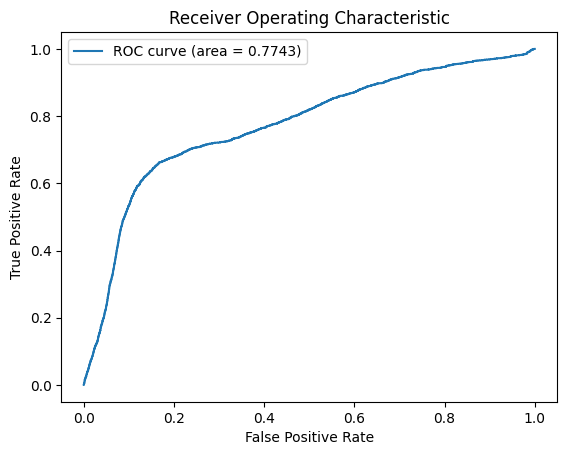

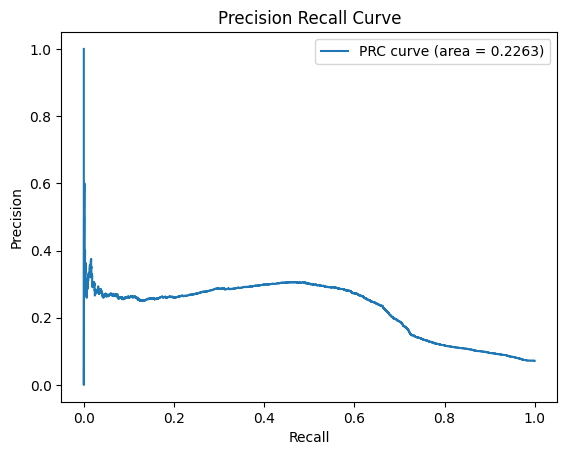

In [ ]:
f1, roc_auc, prc_auc = evaluate_model(label_test, y_pred_test, y_score_test, verbose = True)

In [ ]:
print(f"f1: {f1}, roc_auc: {roc_auc}, prc_auc: {prc_auc}")

f1: 0.3749356223175966, roc_auc: 0.7743290038433722, prc_auc: 0.22625127047779248




```
# Questo è formattato come codice
```

#TimeVQVAE

In [ ]:
#@title Install...
!pip install -r '/content/OurProject/Models/TimeVQVAE-main/requirements.txt'

  Preparing metadata (setup.py) ... done
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl.metadata (1.5 kB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl.metadata (1.6 kB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl.metadata (1.8 kB)
  Using cached nv

In [ ]:
#@title Imports...
import sys
VQVAE_PATH = 'Models/TimeVQVAE-main'
sys.path.append(os.path.join(os.getcwd(),VQVAE_PATH))
from stage1 import *
from utils import *
from experiments.exp_vq_vae import ExpVQVAE
from tqdm import tqdm

dataset_name = 'KUKA'
config = load_yaml_param_settings(os.path.join(VQVAE_PATH, 'configs/config.yaml'))

In [ ]:
#@title Datasets...
from sklearn.preprocessing import OneHotEncoder
from torch.utils.data import Dataset, DataLoader
pd.options.mode.copy_on_write = True
from datasets.kuka_dataset.KukaDataset import KukaDataset
from tqdm import tqdm

dataset_name = 'KUKA'
TRAIN_DATA_PATH = "kuka_dataset/normal"
CAL_DATA_PATH = "kuka_dataset/collisions"#take only file 6
TEST_DATA_PATH = "kuka_dataset/collisions"#take only files 1, 5

categories = np.array(['Low', 'High']).reshape(-1, 1)
encoder = OneHotEncoder(dtype=np.float32)
encoder.fit(categories)

train_dataset = KukaDataset(os.path.join(os.getcwd(),TRAIN_DATA_PATH), test=False, config=config, keep_faulty=False, risk_encoder=encoder, drop_default=True)
#print(train_dataset.kept_columns)
cal_dataset = KukaDataset(os.path.join(os.getcwd(),CAL_DATA_PATH), test=False, config=config, keep_faulty=True, drop_default=True,
                          columns_to_keep=train_dataset.kept_columns, risk_encoder=encoder)
test_dataset = KukaDataset(os.path.join(os.getcwd(),TEST_DATA_PATH), test=True, config=config, keep_faulty=True, drop_default=True,
                          columns_to_keep=train_dataset.kept_columns, risk_encoder=encoder)
config['dataset']['in_channels'] = len(train_dataset.kept_columns) - len(train_dataset.header_columns) - 1

reading data...
preprocessing ... 
windowing ts 1/4
windowing ts 2/4
windowing ts 3/4
windowing ts 4/4
files were read...
95419 (100, 55)
--- Train Dataset ---
df len is: 95419 window shape is: (100, 55)
reading anomalies...
start adding high risk
found the excel and loaded it...
reading data...
preprocessing ... 
windowing ts 1/3
windowing ts 2/3
windowing ts 3/3
files were read...
33978 (100, 55)
--- Train Dataset ---
df len is: 33978 window shape is: (100, 55)
reading anomalies...
start adding high risk
found the excel and loaded it...
reading data...
windowing ts 1/3
windowing ts 2/3
windowing ts 3/3
files were read...
33978 (100, 55)
--- Test Dataset ---
df len is: 33978 window shape is: (100, 55)


In [ ]:
#@title Data Loaders...
batch_size = config['dataset']['batch_sizes']['stage1']

train_data_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
cal_data_loader = DataLoader(cal_dataset, batch_size=1)
test_data_loader = DataLoader(test_dataset, batch_size=1)

In [ ]:
config['trainer_params']['input_length'], config['dataset']['in_channels']

(100, 55)

In [ ]:
#@title Loading TimeVQVAE
exp_vqvae = ExpVQVAE(config['trainer_params']['input_length'], config, len(train_data_loader.dataset))

models_dir = 'saved_models_55ft_w100'
#models_dir = 'saved_models_70ft_w100'
CKPT_PATH = '/content/OurProject/trained_models/TimeVQVAE'

# load
fname = f'vq_model_l-{dataset_name}.ckpt'
ckpt_fname = os.path.join(os.path.join(os.getcwd(),CKPT_PATH), models_dir, fname)
exp_vqvae.vq_model_l.load_state_dict(torch.load(ckpt_fname), strict=False)
fname = f'vq_model_h-{dataset_name}.ckpt'
ckpt_fname = os.path.join(os.path.join(os.getcwd(),CKPT_PATH), models_dir, fname)
exp_vqvae.vq_model_h.load_state_dict(torch.load(ckpt_fname), strict=False)
fname = f'encoder_l-{dataset_name}.ckpt'
ckpt_fname = os.path.join(os.path.join(os.getcwd(),CKPT_PATH), models_dir, fname)
exp_vqvae.encoder_l.load_state_dict(torch.load(ckpt_fname), strict=False)
fname = f'encoder_h-{dataset_name}.ckpt'
ckpt_fname = os.path.join(os.path.join(os.getcwd(),CKPT_PATH), models_dir, fname)
exp_vqvae.encoder_h.load_state_dict(torch.load(ckpt_fname), strict=False)
fname = f'decoder_l-{dataset_name}.ckpt'
ckpt_fname = os.path.join(os.path.join(os.getcwd(),CKPT_PATH), models_dir, fname)
exp_vqvae.decoder_l.load_state_dict(torch.load(ckpt_fname), strict=False)
fname = f'decoder_h-{dataset_name}.ckpt'
ckpt_fname = os.path.join(os.path.join(os.getcwd(),CKPT_PATH), models_dir, fname)
exp_vqvae.decoder_h.load_state_dict(torch.load(ckpt_fname), strict=False)

exp_vqvae.eval()

ExpVQVAE(
  (encoder_l): VQVAEEncoder(
    (encoder): Sequential(
      (0): VQVAEEncBlock(
        (block): Sequential(
          (0): Conv2d(110, 128, kernel_size=(3, 4), stride=(1, 2), padding=(1, 1), padding_mode=replicate)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.01, inplace=True)
        )
      )
      (1): VQVAEEncBlock(
        (block): Sequential(
          (0): Conv2d(128, 128, kernel_size=(3, 4), stride=(1, 2), padding=(1, 1), padding_mode=replicate)
          (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): LeakyReLU(negative_slope=0.01, inplace=True)
        )
      )
      (2): Sequential(
        (0): ResBlock(
          (convs): Sequential(
            (0): LeakyReLU(negative_slope=0.01)
            (1): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
            (2): BatchNorm2d(128, eps=1e-05, momentu

In [ ]:
#@title Estimates for calibration...
# KEEP BATCH SIZE = 1 HERE, PLEASE
#mapping = {1: 'Low', 0: 'High'}
all_losses = []
window_label_pos = config['trainer_params']['input_length'] - 1
for batch in tqdm(cal_data_loader): #iterating through test ds with step B

    x , y = batch[0], batch[1]
    #x = x.to(gpu_device_idx) #comment if using the CPU

    recons_loss, _, _ = exp_vqvae.forward((x,))

    lf_time = recons_loss['LF.time'].detach().item()
    hf_time = recons_loss['HF.time'].detach().item()
    lf_timefreq = recons_loss['LF.timefreq'].detach().item()
    hf_timefreq = recons_loss['HF.timefreq'].detach().item()

    #print(y.shape)
    #curr_label = mapping[torch.argmax(y[0, :, 0]).item()]
    curr_label_encoded = y[0, :, 0].unsqueeze(0).numpy()
    curr_label = encoder.inverse_transform(curr_label_encoded)[0, 0]

    all_losses.append((np.array([lf_time, hf_time, lf_timefreq, hf_timefreq]), curr_label))

# Separate the data and labels
data = [tup[0] for tup in all_losses]
labels = [tup[1] for tup in all_losses]

# Vstack the data to create a 2-dimensional numpy array
data_array = np.vstack(data)

# Convert the labels to a 1-dimensional numpy array
labels_array = np.array(labels)

100%|██████████| 33978/33978 [19:07<00:00, 29.60it/s]


In [ ]:
data_array.shape, labels_array.shape

((33978, 4), (33978,))

In [ ]:
optimize = True
param_grid = {'estimator__C': np.logspace(0, 5, 6), 'estimator__gamma': np.logspace(-5, 0, 6)}

if optimize:
  cal_search = GridSearchCV(CalibratedClassifierCV(SVC(probability=True), cv=3), param_grid, cv=3, verbose=1, scoring='f1')
  cal_search.fit(data_array, labels_array)
  cal_vqvae = cal_search.best_estimator_
  print(cal_search.best_params_)
else:
  cal_vqvae = CalibratedClassifierCV(SVC(probability=True, C=10, gamma=1e-3))
  cal_vqvae.fit(data_array, labels_array[:data_array.shape[0]])

Fitting 3 folds for each of 36 candidates, totalling 108 fits


# Telemanom



The Telemanom model utilizes Long Short-Term Memory (LSTM) neural networks to manage and analyze large volumes of telemetry data. This approach demonstrates how such networks can effectively handle the complexity and scale of the data. An innovative, unsupervised, and nonparametric method for setting anomaly thresholds has been introduced, designed during a pilot implementation for effective anomaly detection. The model also includes strategies to minimize false positives and presents key insights and lessons learned during development. The original model has been modified to accept various configuration parameters directly as arguments at model startup, and it has been converted from TensorFlow to PyTorch. [Link original paper](https://arxiv.org/pdf/1802.04431)


**Model Training**
---

The model undergoes a training phase of 20 epochs for each channel. During this training phase, the model learns the normal behavior of the channel by predicting the current timestamp, considering approximately 300 samples from previous timestamps (a hyperparameter) for prediction. Before the training phase, each channel undergoes a model weight calibration. Once the training cycles for each channel are completed, inference is conducted using a dataset containing anomalies to determine if the learned normal behavior deviates from that observed in the anomaly dataset. The various anomalies predicted across the channels are then summed and pruned based on their scores; anomalies falling below a dynamically calculated threshold are disregarded.

Below the list of arguments accepted by the model:

1. `--run_id`: Specifies a directory path in the format `trained_models/telemanom/{run_id}` to locate parameters for initialization. (Type: string, Default: None)
2. `--batch_size`: Number of values to evaluate in each batch. (Type: integer)
3. `--window_size`: Number of consecutive batches used in the calculation of errors. (Type: integer)
4. `--smoothing_perc`: Determines the size of the window used in EWMA smoothing. (Type: float)
5. `--error_buffer`: Number of values surrounding an error that are included in the sequence. (Type: integer)
6. `--l_s`: Minimum number of precedent telemetry data required for analysis. (Type: integer)
7. `--n_predictions`: Number of predictions per timestamp. (Type: integer)
8. `--activation`: Specifies the activation layer used in the model. (Type: string, Options : ["relu","sigmoid","leakyReLu"])
10. `--dropout`: Determines the dropout rate for various layers in the model. (Type: float)
11. `--weight_decay`: Specifies L2 regularization. (Type: float)
12. `--learning_rate`: Learning rate for the model. (Type: float)
13. `--lstm_batch_size`: Batch size for LSTM layers. (Type: integer)
14. `--layer_LSTM`: Specifies the number of LSTM layers to include in the model. (Type: integer)
15. `--epochs`: Number of epochs for training. (Type: integer)
16. `--p`: Minimum percentage decrease between the maximum errors in anomalous sequences. (Type: float)
17. `--save_on_drive`: If set, saves information on the connected drive. (Action: store_true)
18. `--skip_graphics`: If set, avoids creating graphical files for results. (Action: store_true)
20. `--train`: If set, applies training to the model. (Action: store_true)
21. `--predict`: Forces the model to generate new predictions; if not set, uses predictions from the `trained_models/telemanom/{run_id}`. (Action: store_true)
22. `--num_channels`: Number of channels to consider. (Type: integer)
23. `--threshold`: If set, calculates a dynamic threshold for the final anomalies. (Action: store_true)

These parameters provide detailed control over the model's configuration and operation, catering to a wide range of needs and applications.

**Note:** When the `--train` parameter is passed, the model is forced to execute the training phase. However, if there are existing model weights from a previous training session in the path `trained_models/telemanom/{run_id}`, those weights will be retrieved. Passing the `--train` parameter will cause the model to perform both the training phase and the final inference. It is important to note that the duration of the training phase can vary depending on the `--layer_LSTM` parameter and the number of layers per each LSTM, which is a hyperparameter defined in the model's `config.yaml`. Increasing the number of LSTM layers and the number of layers per LSTM can significantly alter the time required for training the model.

In [ ]:
!python "/content/OurProject/Models/telemanom/main.py" --train --predict --threshold --sample_rate 0.1s

**Model Inference**

If you wish to execute only the inference phase, bypassing the training phase, you must remove the `--train` parameter from the arguments (which otherwise forces the model to perform the training). However, to properly conduct the inference phase, the folder `trained_models/telemanom/{run_id}` must exist and contain at least the subfolders "models" (which holds the model weights for each channel) and "y_hat" (the predictions made by the model for various timestamps). If the `--predict` argument is passed, the model will load the channel-specific model weights from `trained_models/telemanom/{run_id}/models` to make predictions. If `--predict` is not passed, it will retrieve previous predictions from `trained_models/telemanom/{run_id}/y_hat` to calculate the model's accuracy without recalculating the prediction.

Furthermore, the model saves configuration information and details about the model (such as the number of LSTM layers used and the number of layers per LSTM) in the path `trained_models/telemanom/{run_id}/info_model/info_model.txt`. For each step, the model saves both on-screen and in a log file the various outputs obtained during the run (log path: `trained_models/telemanom/{run_id}/{run_id}.log`).

To aid in visually understanding the prediction results of anomalies, logic has been implemented that saves a graph of both actual and predicted anomalies for each channel during the inference phase. Additionally, the various predictions are summed and pruned according to their score. The pruning of anomalies only occurs if the `--threshold` argument is passed; otherwise, the final anomaly pruning does not take place. The graphical results obtained for the various channels and the final model outcome are saved as .pdf files in the path `trained_models/telemanom/{run_id}/plot_predictions/`.

It is recommended to refer to both the on-screen logs and those saved in log files (which have the same results) for a better understanding of the model's behavior and to know where the various model results are stored; they should be comprehensive.

In [ ]:
!python "/content/OurProject/Models/telemanom/main.py" --predict --threshold --sample_rate 0.1s --run_id "2024-07-30_22.17.34"